In [77]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.io import fits
import glob
import pandas as pd
import ast

plt.style.use('seaborn-white')
mpl.rcParams.update({'font.size': 16})

## Extending Fe Calibration to Additional Elements

We've calibrated our TAME measurements by using a sample of by-hand equivalent widths for comparison. As we expand our linelist, we'll want to apply similar calibration to those lines as well. This notebook explores general trends in the Fe calibration to use as a 0th order calibration for lines where we have no by-hand measurements.

### Distribution of Fe Lowercut Values

What is the most common lowercut value preferred by the Fe lines?

In [69]:
df = pd.read_csv("tame_linecorr.csv", delim_whitespace = True)

feII = [5018.44, 5234.63,5284.1,5325.56,5414.05,5425.25,5991.37,
        6084.1,6149.25,6247.58,6416.92,6432.68,6456.38]

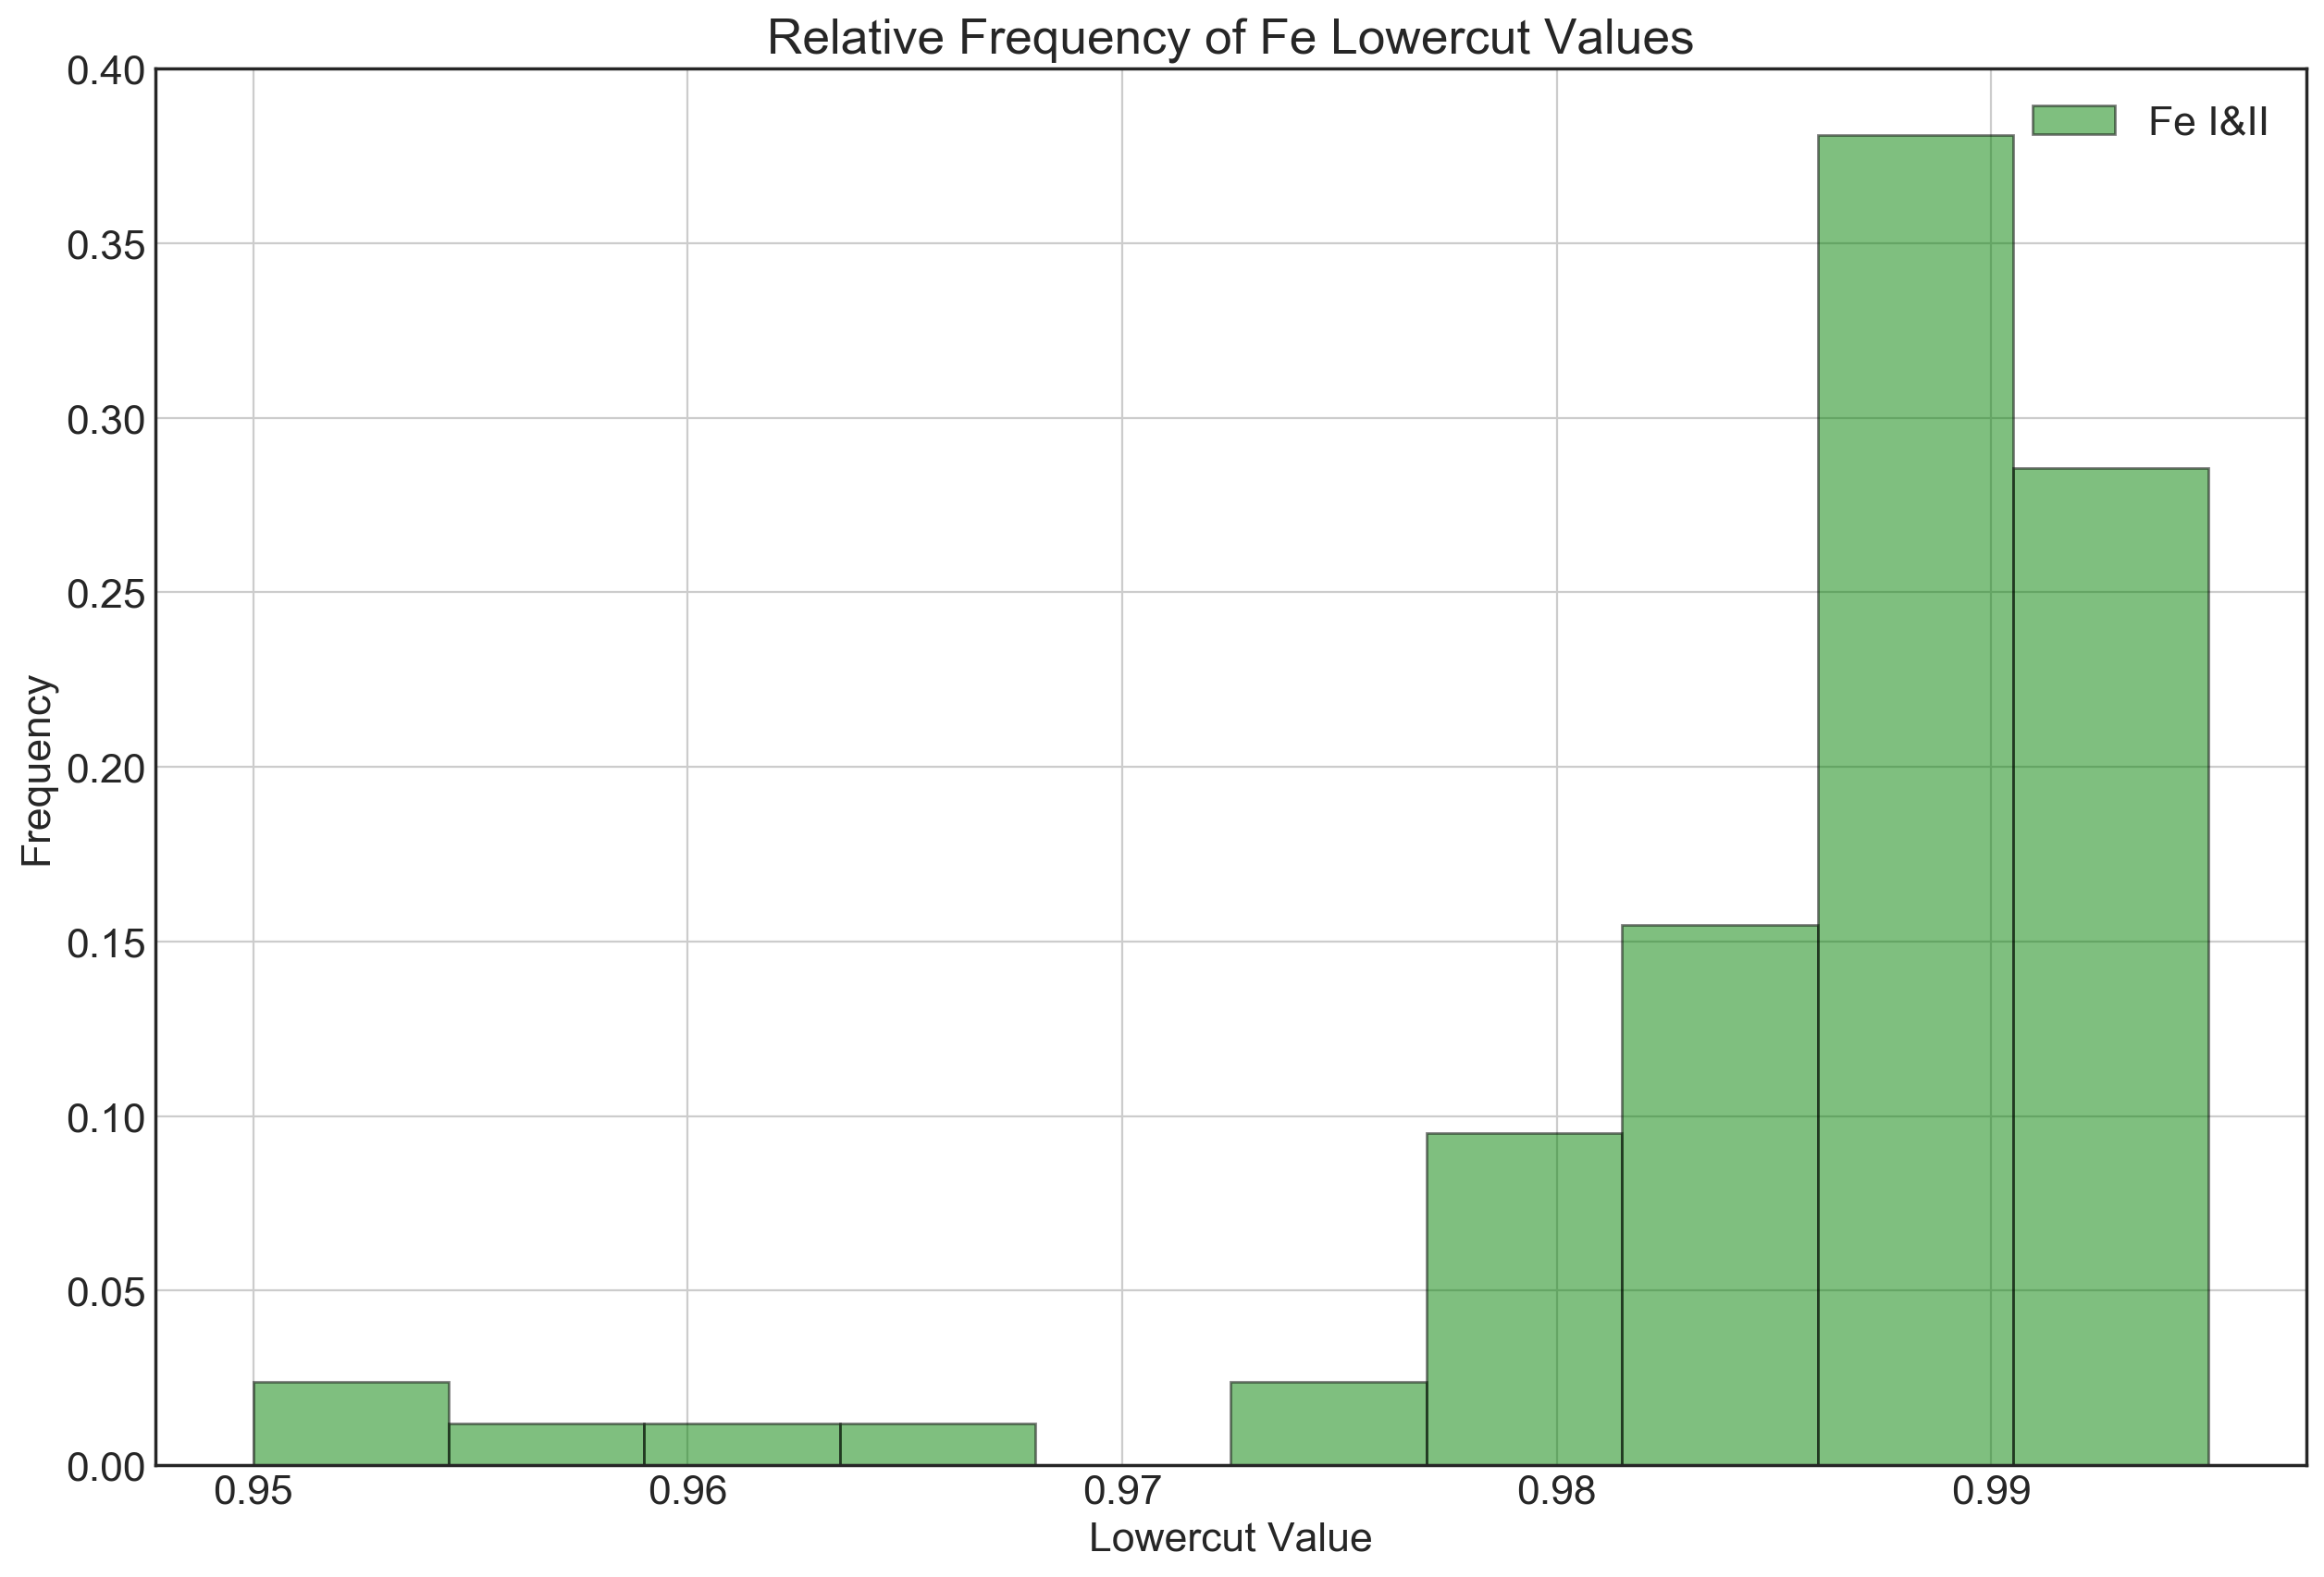

In [70]:
fig = plt.figure(figsize=(15,10), dpi = 200)
plt.grid()
plt.title("Relative Frequency of Fe Lowercut Values")
plt.xlabel("Lowercut Value")
plt.ylabel("Frequency")

bins=np.histogram(np.hstack(df['Lowercut']), bins=10)[1] #designate a consistent binsize across 
plt.hist(df['Lowercut'], histtype='bar', ec='black', bins=bins, color='g', alpha=0.5, 
         weights=np.zeros_like(df['Lowercut']) + 1. / len(df['Lowercut']), label = "Fe I&II")
plt.legend()

Is there a distribution difference between the Fe ionization states?

From this sample size, no. Both states have similar relative frequency for the common lowercut values and differ for the less common ones (which is likely just outlier noise). Since these are similar, this strengthens the case for assuming a similar distribution of lowercut values for any given element. Essentially, this distribution likely represents systematic TAME selection rather than element specific selection.

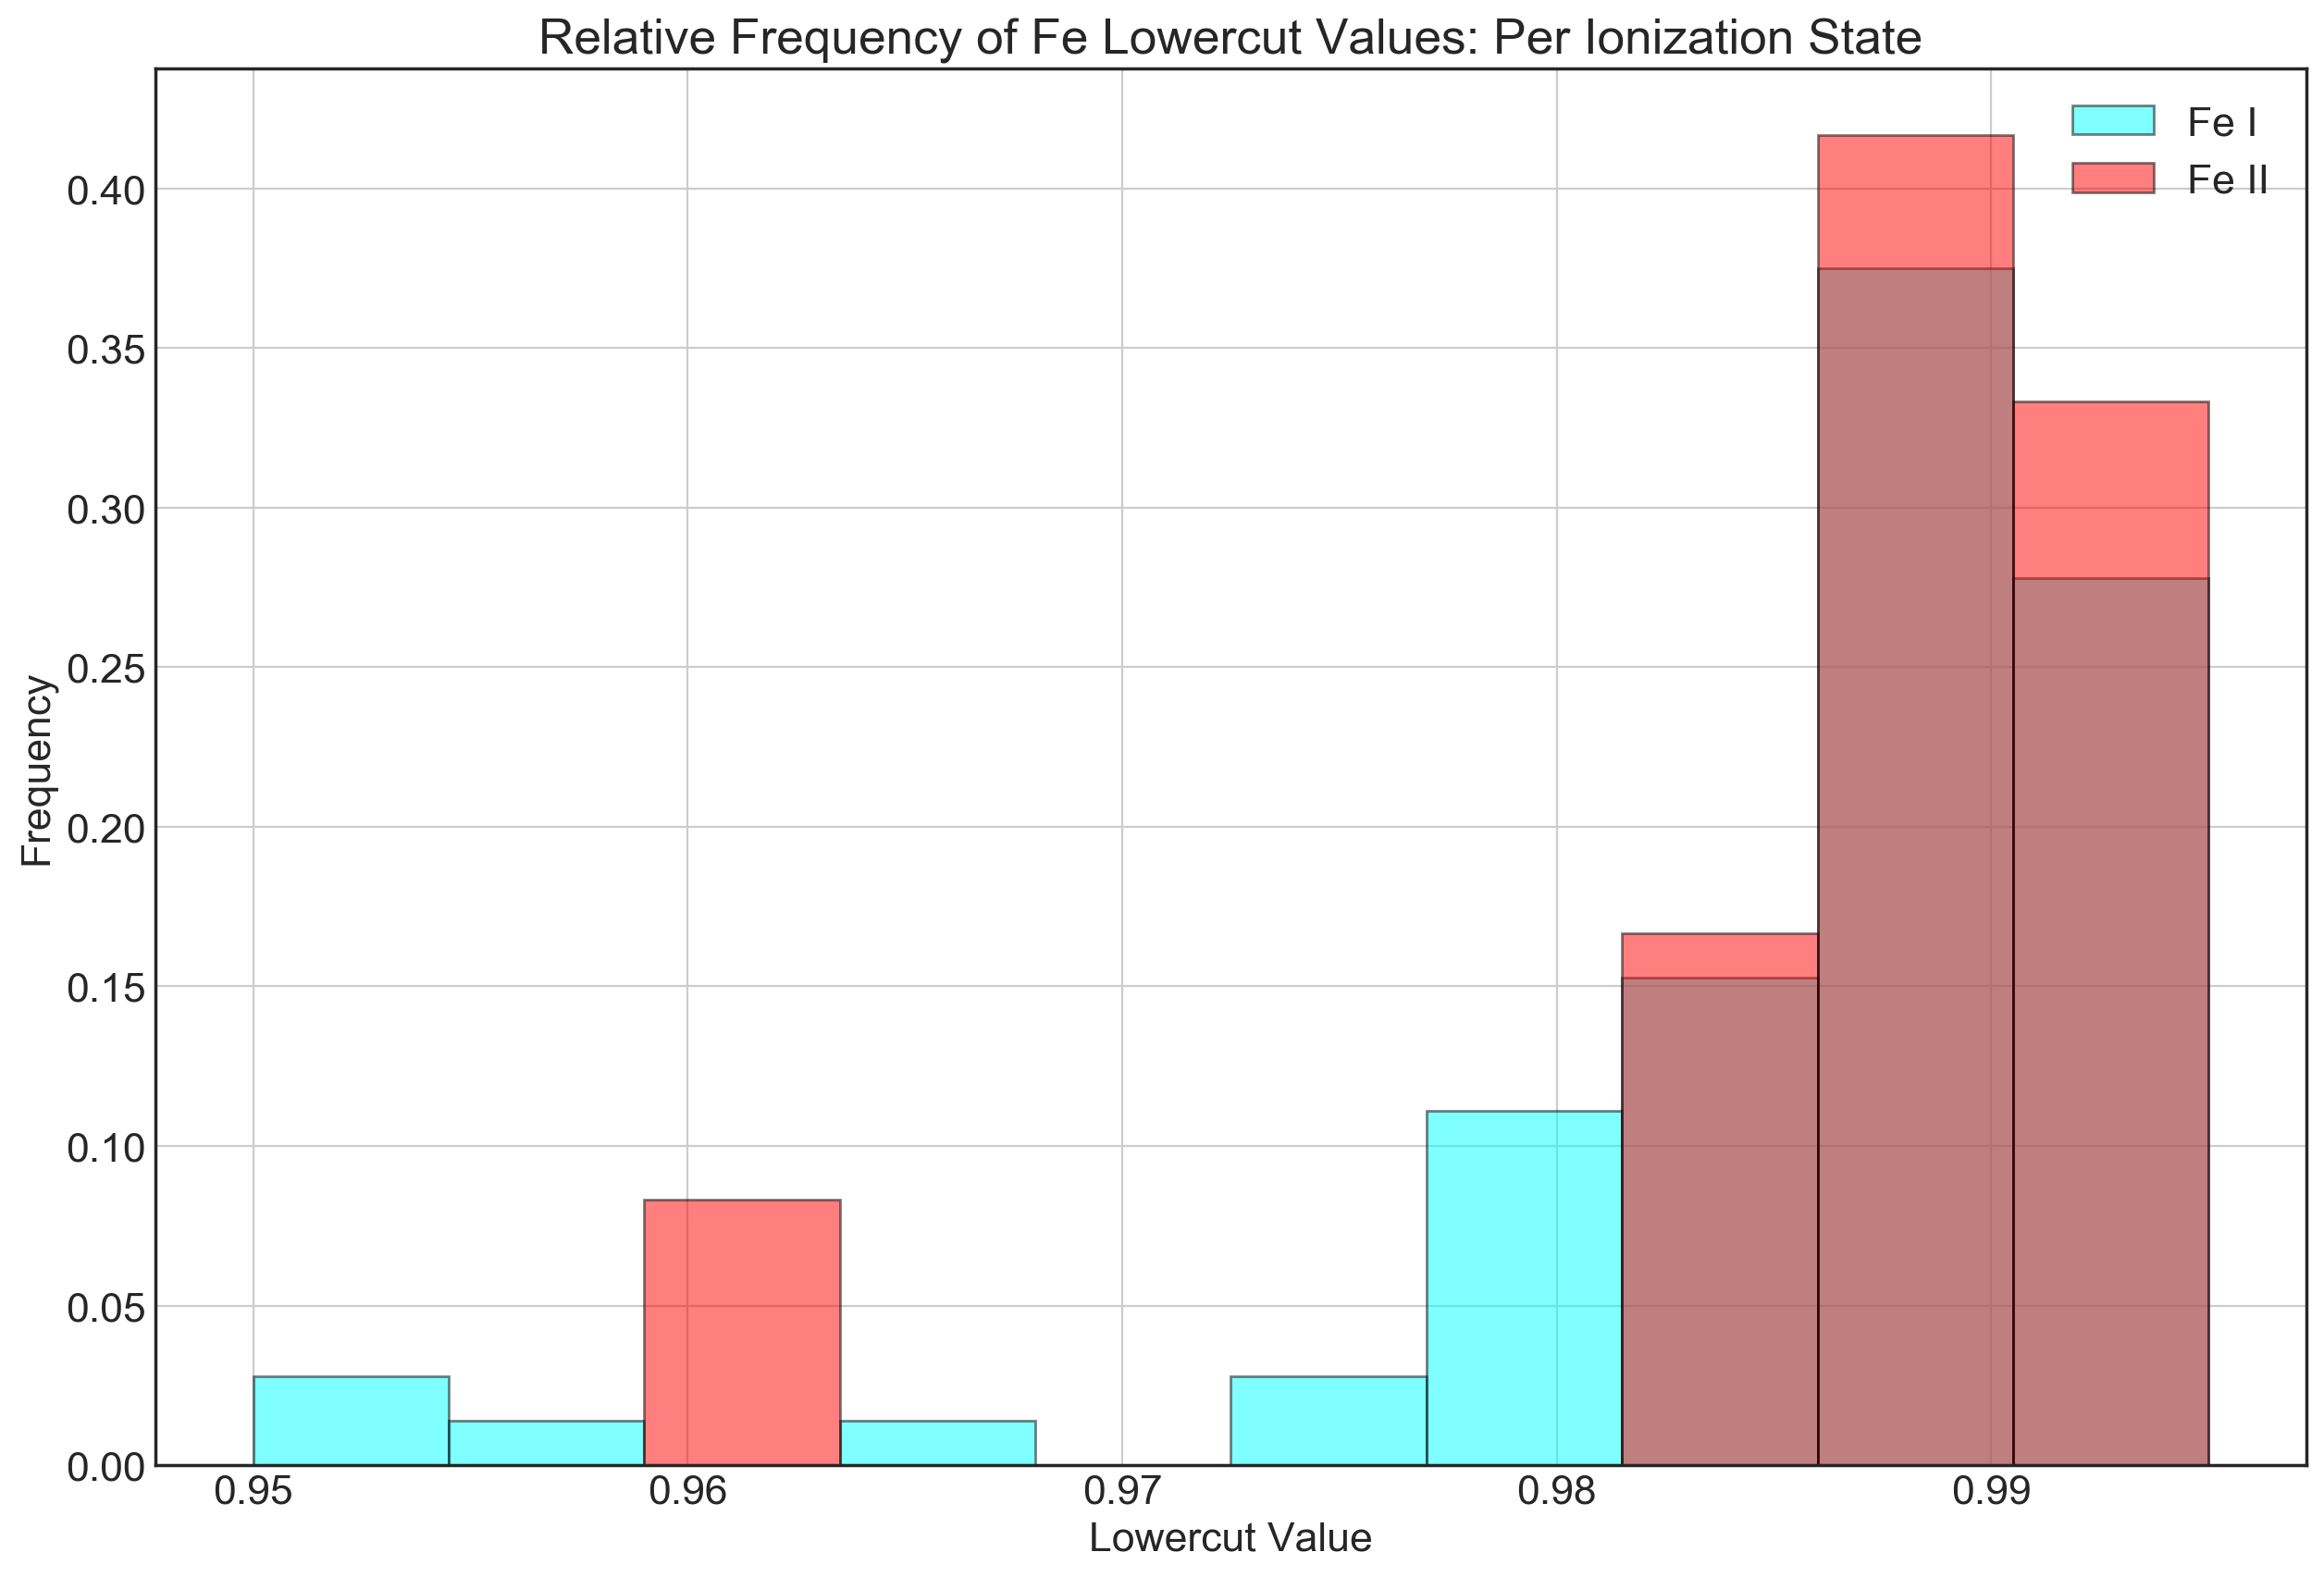

In [68]:
feI_lc = []
feII_lc = []
for line in np.array(df['Line']):
    idx = df[df['Line']==line].index.values.astype(int)[0]
    if line in feII:
        feII_lc.append(df['Lowercut'][idx])
    else:
        feI_lc.append(df['Lowercut'][idx])

fig = plt.figure(figsize=(15,10), dpi = 200)
plt.grid()
plt.title("Relative Frequency of Fe Lowercut Values: Per Ionization State")
plt.xlabel("Lowercut Value")
plt.ylabel("Frequency")

bins=np.histogram(np.hstack(df['Lowercut']), bins=10)[1] #designate a consistent binsize across 


plt.hist(feI_lc, histtype='bar', ec='black', bins=bins, color='cyan', alpha=0.5, 
         weights=np.zeros_like(feI_lc) + 1. / len(feI_lc), label = "Fe I")
plt.hist(feII_lc, histtype='bar', ec='black', bins=bins, color='r', alpha=0.5, 
         weights=np.zeros_like(feII_lc) + 1. / len(feII_lc), label="Fe II")

plt.legend()

### Distribution of Uncertainties and Offset Values for a Given Lowercut Value -- Deriving General Calibration Values for all Elements.

For a given lowercut value, across all Fe lines how consistent do its uncertainties and offset values stay? Below are the three most common lowercut values from before. The distribution of uncertainties and offsets are shown. 

For uncertainty, the typical value seems to range anywhere from 2 mA to 10 mA. This spread is expected as we've included lowercut calibration values from all lines, including both those that have the particular lowercut value as its optimal value and those that don't. From this distribution, we can obtain a generalized uncertainty for the lowercut value itself derived at a confidence value of our choosing.

For offset, the range of values depends on the lowercut value. In order to derive a generalized offset procedure, we can take the median offset for the line, and add the spread of offsets as an additional uncertainty. With this additional uncertainty added onto the generalized uncertainty, we can derive a cited uncertainty and offset value per line.

From this, it appears that choosing a lowercut value of 0.99 will yield the best generalized results.

In [71]:
df_v2 = pd.read_csv("tame_linecorr_v2.csv", delim_whitespace = True)

feII = [5018.44, 5234.63,5284.1,5325.56,5414.05,5425.25,5991.37,
        6084.1,6149.25,6247.58,6416.92,6432.68,6456.38]

Lowercut: 0.985
Generalized Uncertainty: 4.9108
Generalized Offset: -1.9 (Apply this)
Generalized Offset Uncertainty: 1.775
Lowercut Total Uncertainty: 6.6858
Lowercut: 0.99
Generalized Uncertainty: 4.3108
Generalized Offset: -0.625 (Apply this)
Generalized Offset Uncertainty: 1.714
Lowercut Total Uncertainty: 6.024800000000001
Lowercut: 0.995
Generalized Uncertainty: 4.9808
Generalized Offset: 1.15 (Apply this)
Generalized Offset Uncertainty: 1.738
Lowercut Total Uncertainty: 6.7188


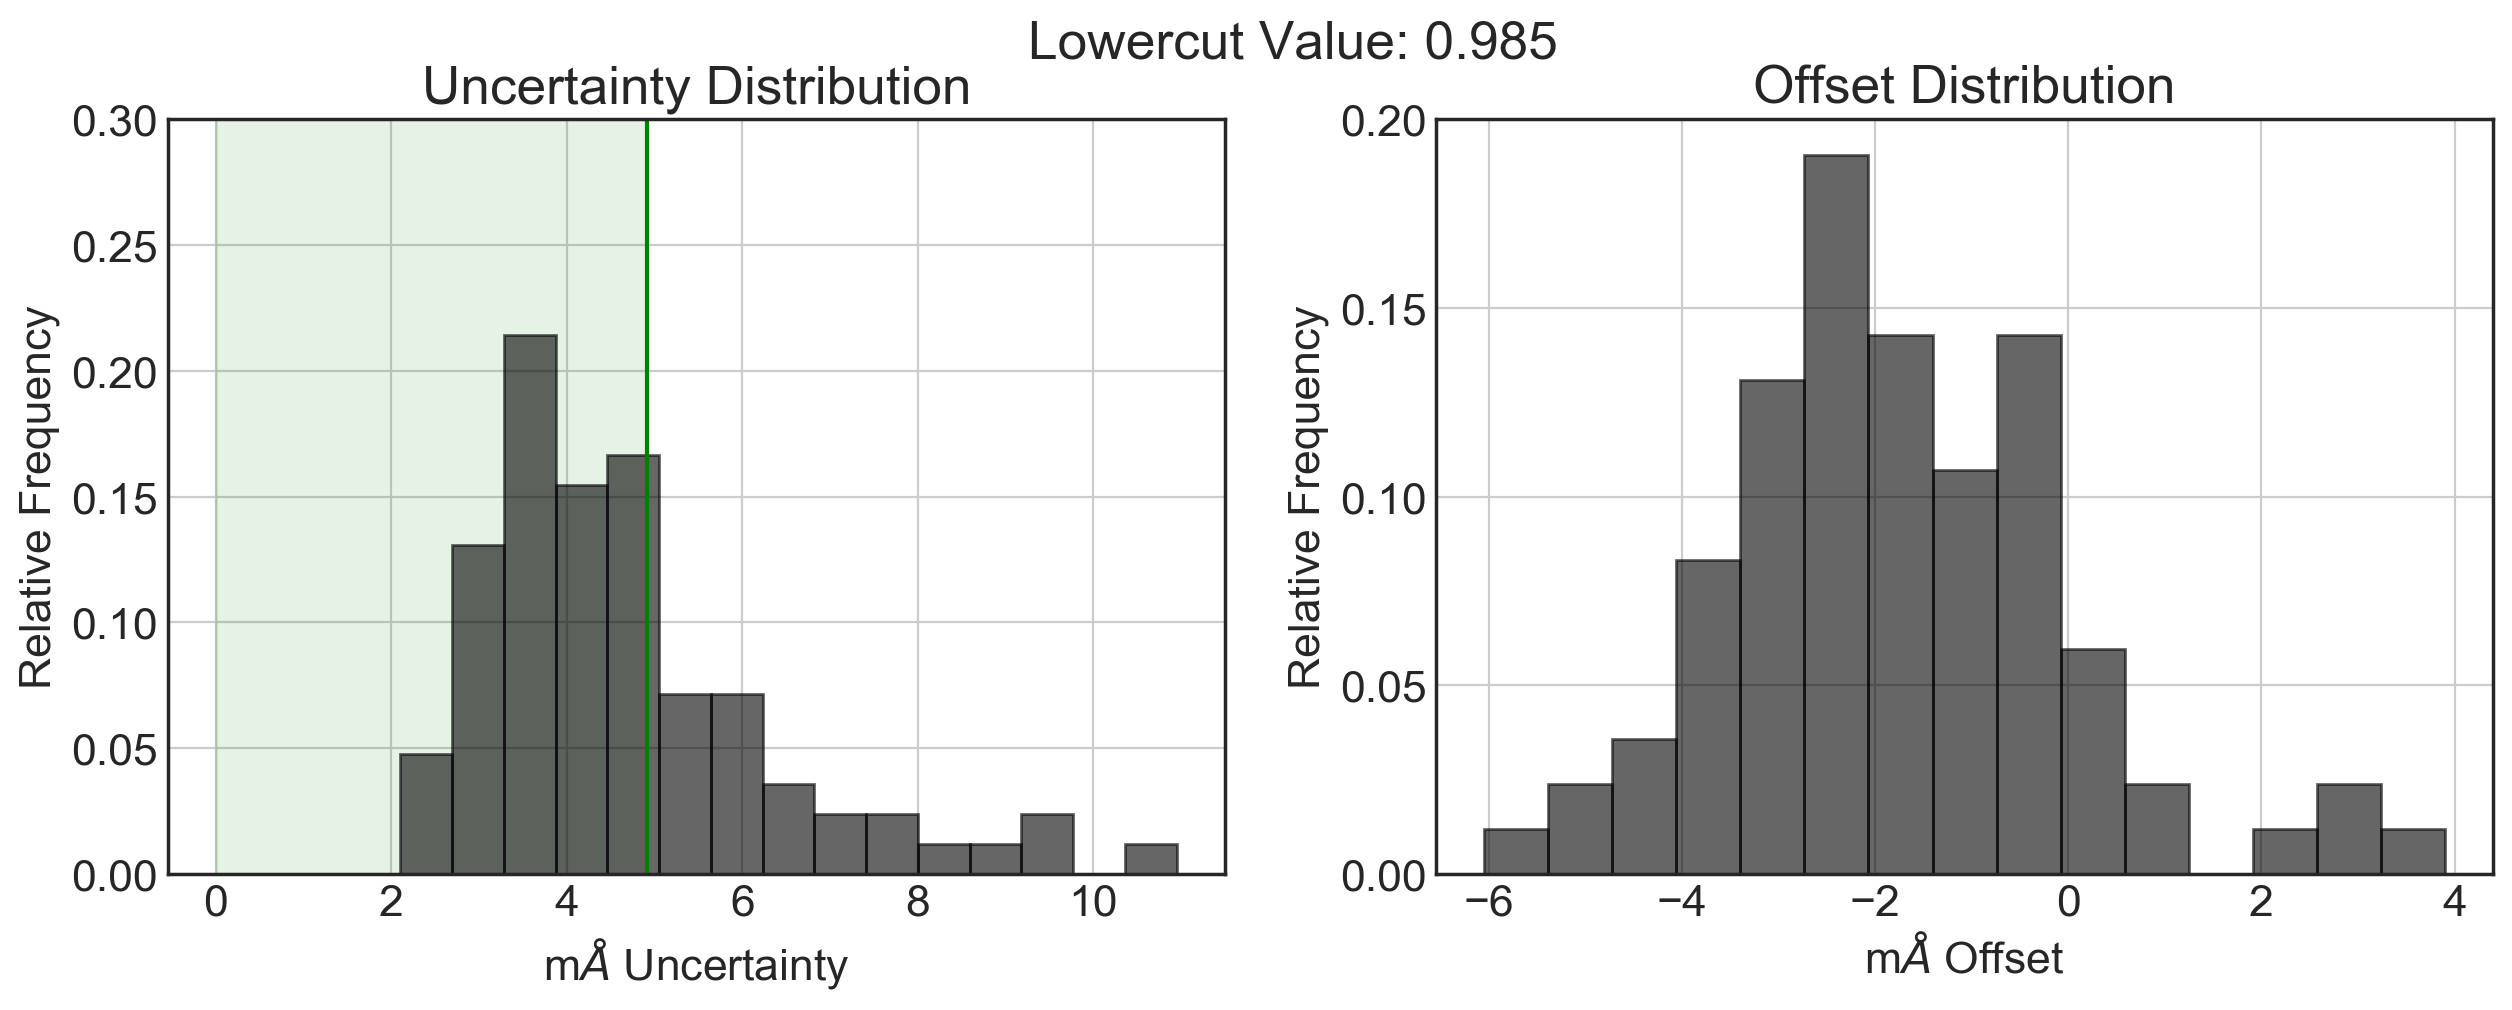

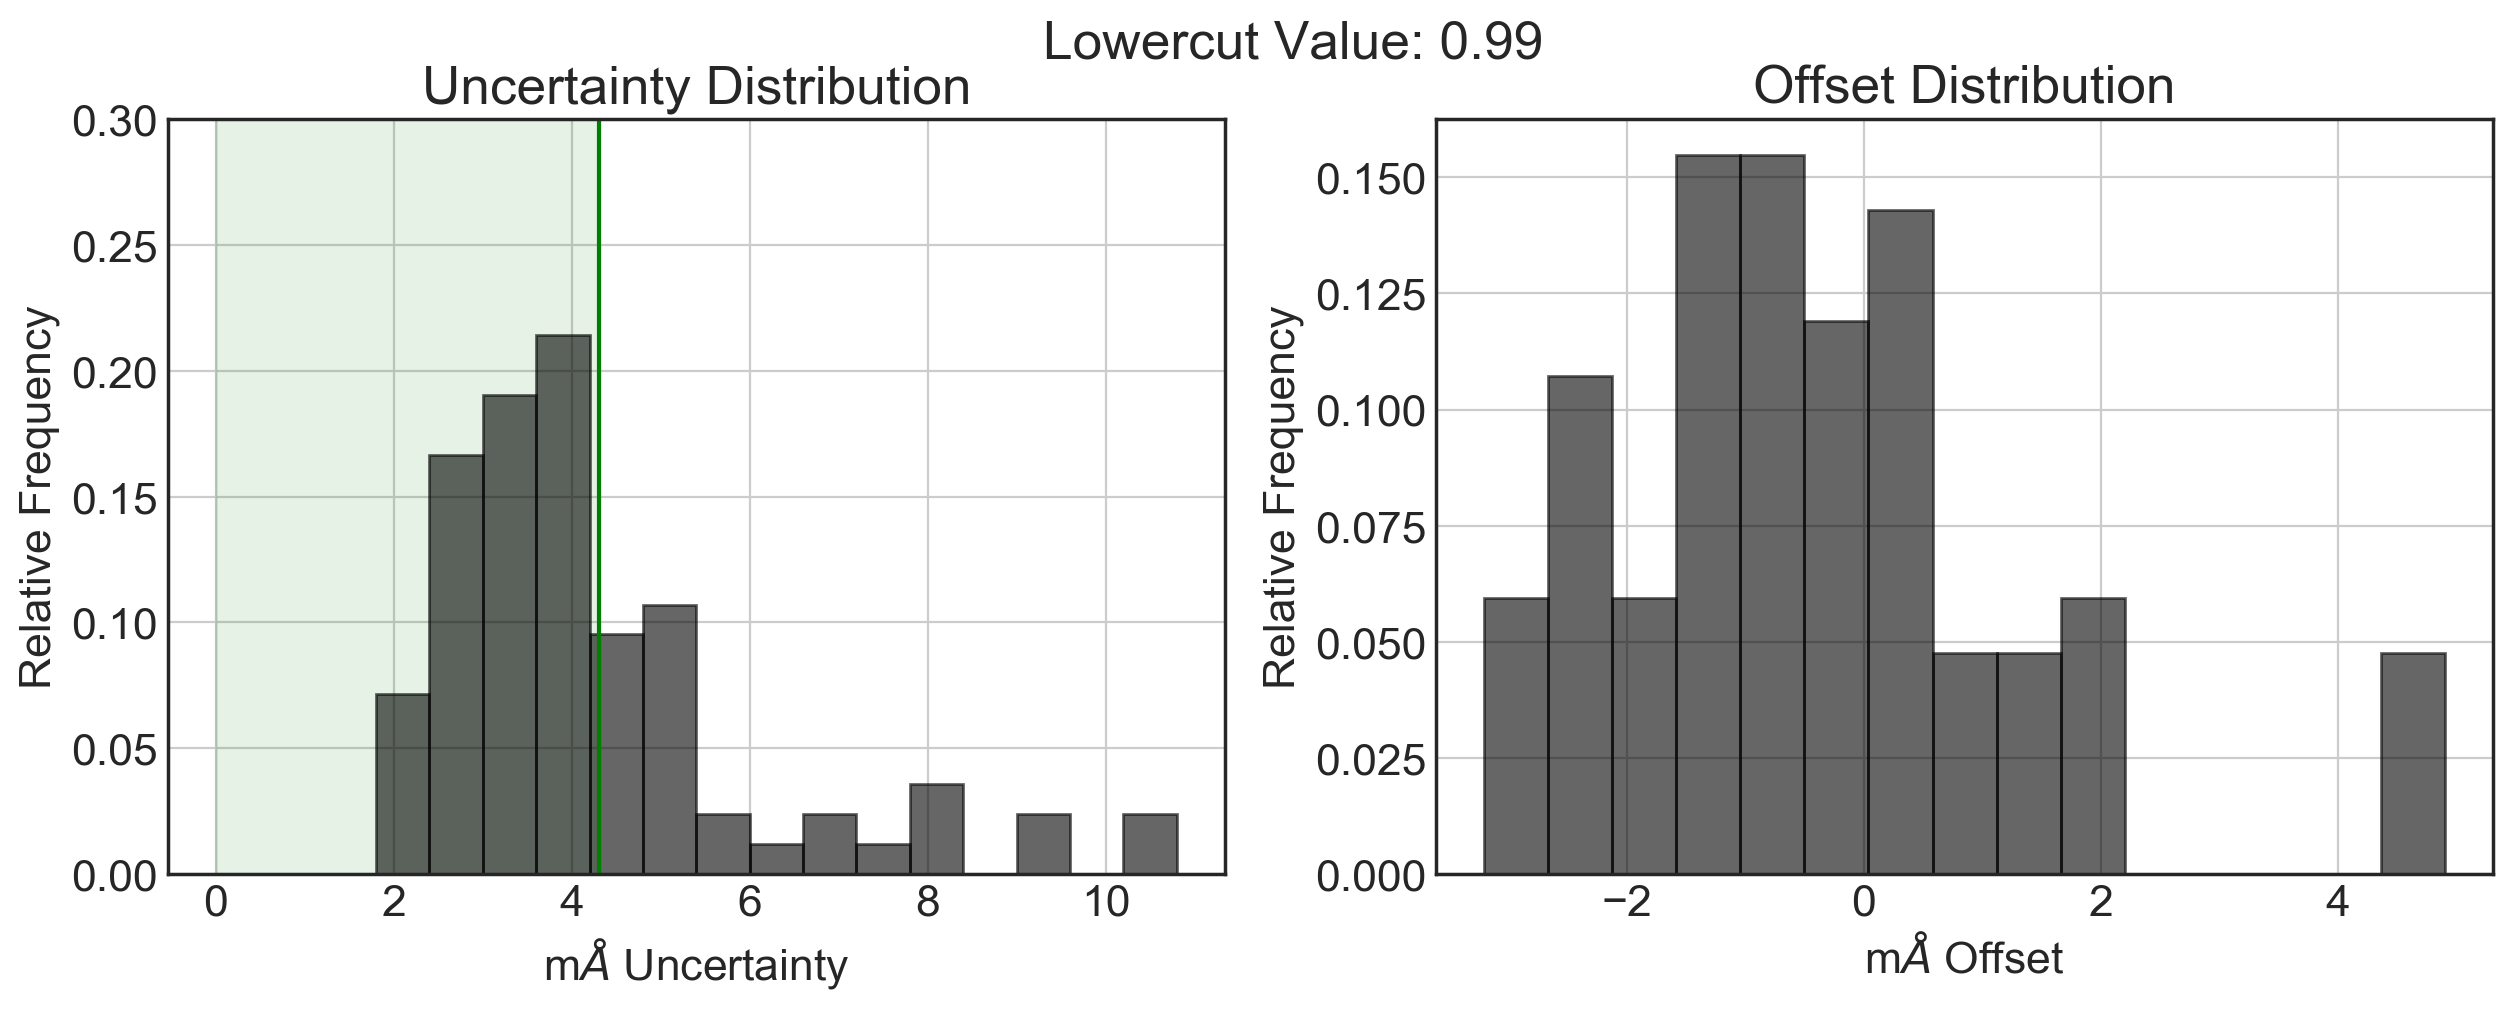

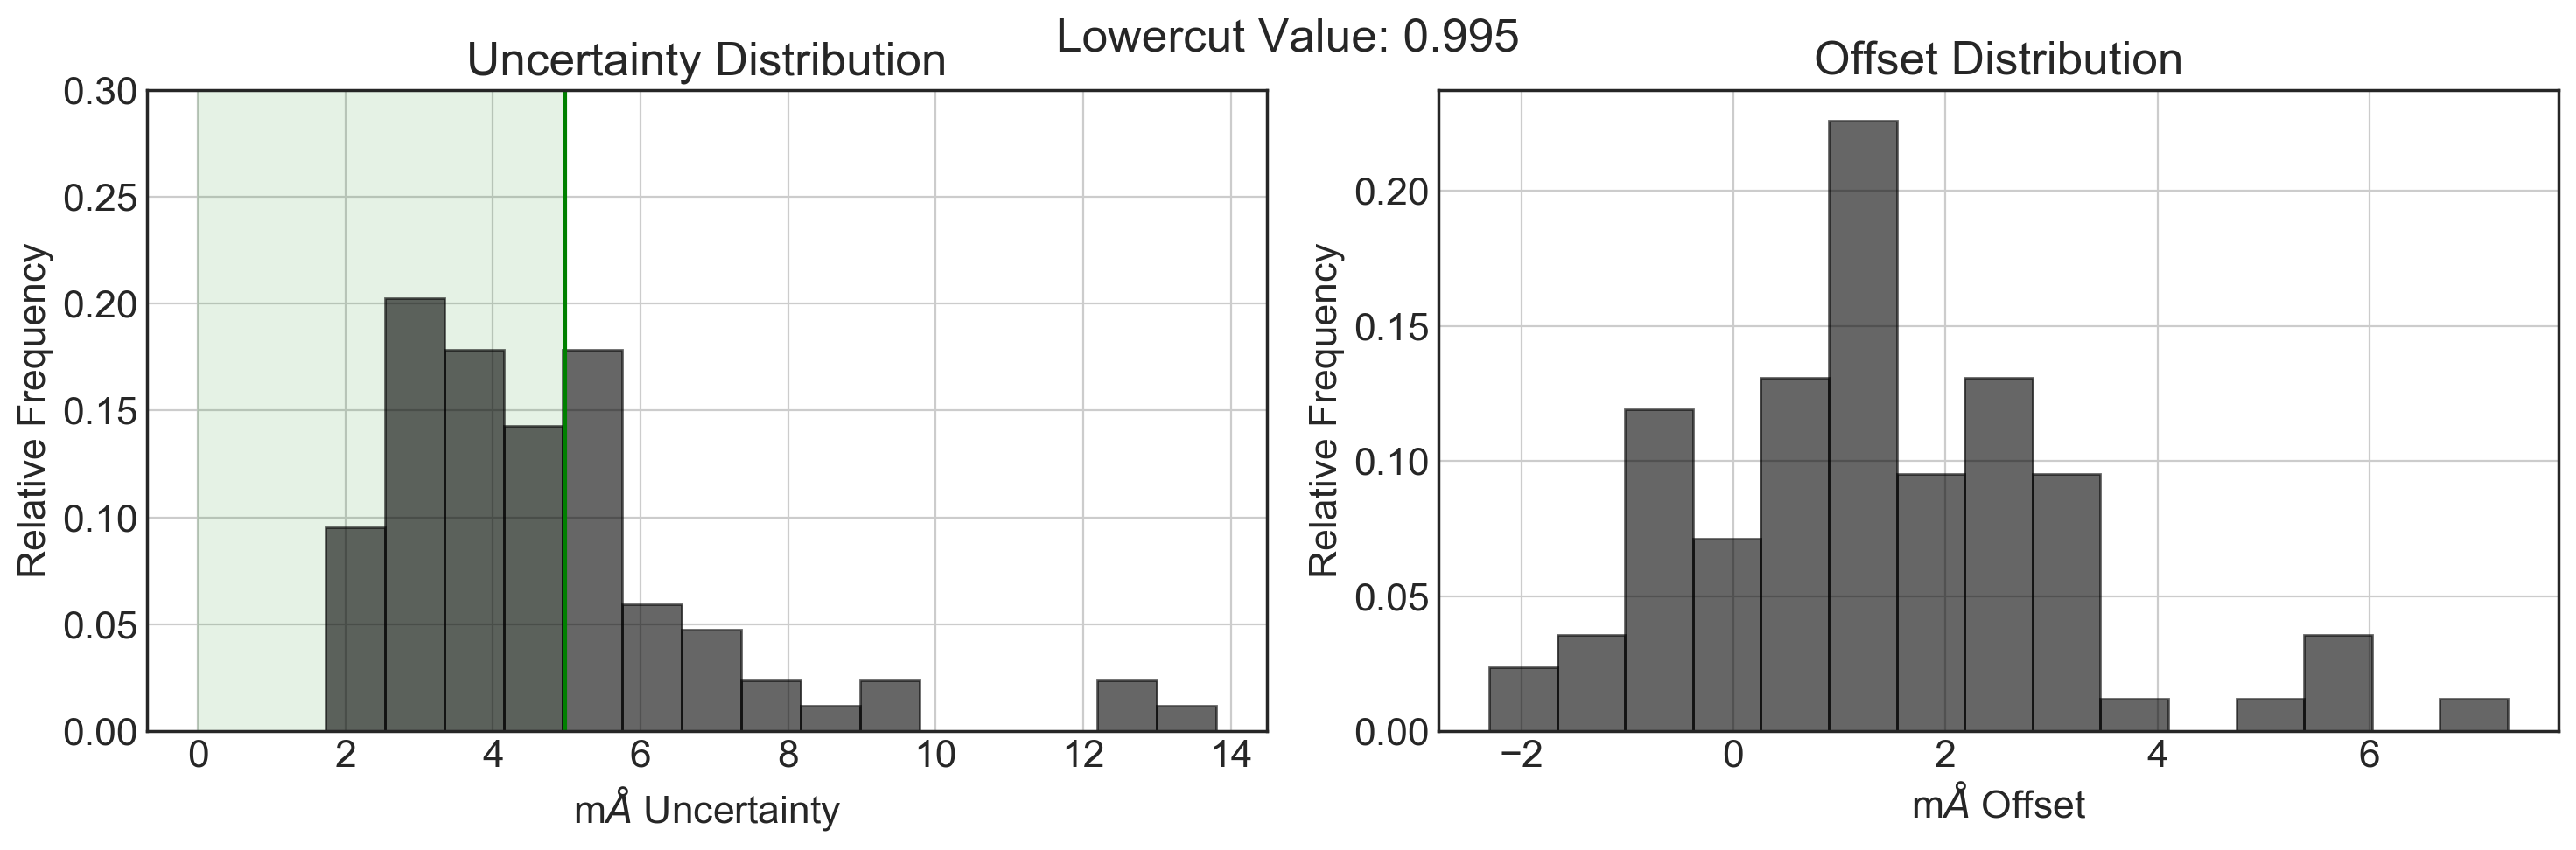

In [203]:
#fig, axes = plt.subplots(1,3, figsize = (15,5), dpi = 200)
common_lc = [0.985, 0.99, 0.995]

for lc in common_lc:
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5), dpi = 200)
    fig.suptitle("Lowercut Value: {}".format(lc))
    offset = []
    unc = []
    for row in df_v2.iterrows():
        vals = ast.literal_eval(row[1]['Calibration Values'])
        lc_vals = [item for item in vals if lc in item][0]
        unc.append(lc_vals[1])
        offset.append(lc_vals[2])
    
    gen_unc = np.percentile(unc, 68)
    gen_offset = np.round(np.median(offset),3)
    gen_offset_dev = np.round(np.std(offset),3)
    
    bins=np.histogram(np.hstack(unc), bins=15)[1] #designate a consistent binsize across 
    ax1.hist(unc, histtype='bar', ec='black', bins=bins, color='k', alpha=0.6, 
         weights=np.zeros_like(unc) + 1. / len(unc))
    ax1.grid()
    ax1.set_title("Uncertainty Distribution")
    ax1.set_ylabel("Relative Frequency")
    ax1.set_xlabel(r"m$\AA$ Uncertainty")
    ax1.axvline(gen_unc, color = 'g')
    ax1.set_ylim(0,0.3)
    fill_range = np.arange(0,gen_unc, 0.001)
    ax1.fill_between(fill_range, 0,0.3, color = 'g', alpha =0.1)
    #ax1.text(0.5,0.9,"Median: {}".format(np.round(np.median(offset),3)), transform=ax1.transAxes)
    #ax1.text(0.5,0.82,"Standard Deviation: {}".format(np.round(np.std(offset),3)), transform=ax1.transAxes)
    
    bins=np.histogram(np.hstack(offset), bins=15)[1] #designate a consistent binsize across 
    ax2.hist(offset, histtype='bar', ec='black', bins=bins, color='k', alpha=0.6, 
         weights=np.zeros_like(offset) + 1. / len(offset))
    ax2.grid()
    ax2.set_title("Offset Distribution")
    ax2.set_ylabel("Relative Frequency")
    ax2.set_xlabel(r"m$\AA$ Offset")
    #ax2.axvline(gen_offset, color = 'r')
    #ax2.text(0.5,0.9,"Median: {}".format(np.round(np.median(offset),3)), transform=ax2.transAxes)
    #ax2.text(0.5,0.82,"Standard Deviation: {}".format(np.round(np.std(offset),3)), transform=ax2.transAxes)
    
    
    
    print("===============")    
    print("Lowercut: {}".format(lc))
    print("Generalized Uncertainty: {}".format(gen_unc))
    print("Generalized Offset: {} (Apply this)".format(gen_offset))
    print("Generalized Offset Uncertainty: {}".format(gen_offset_dev))
    print("Lowercut Total Uncertainty: {}".format(gen_unc + gen_offset_dev))
 
plt.tight_layout()